## To dos:

### ipmag functions to be made:

- [ ] ipmag.find_EI() clean up for ipmag inclusion including introductory function comments
- [ ] ipmag.dmag_magic() find way to filter by site


### [ ]update ipmag.sb_vgp_calc so that column fields can be specified (similar to what was done with vgp_calc)

### ipmag/pmag functions that already exist that should be demonstrated:

- [ ] ipmag.sb_vgp_calc
- [ ] ipmag.download_magic

In [1]:
# With the PmagPy folder in the PYTHONPATH, 
# the function modules from PmagPy can be imported
import pmagpy.ipmag as ipmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.pmag as pmag

from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
# %config InlineBackend.figure_formats = {'svg',}

## Download Magic File

To retrieve data from the MagIC database, you will download a contribution file that will look something like this: *magic_contribution_10231.txt*.

A "contribution" is often made up of several MagIC files (one for each magnetic experiment) that have been concatenated into a single text file. The function **ipmag.download_magic** is able to recognize and separate these different experiments. It then writes individual text files for each (the file names are generated automatically by experiment). 

Let's unpack the MagIC contribution of Swanson-Hysell et al., 2014 (MagIC contribution 10231).

In [ ]:
ipmag.download_magic('magic_contribution_10231.txt', 
                     dir_path='./Additional_Notebook_Output/download_magic',
                     input_dir_path='./Example_Data/Swanson-Hysell2014',
                    overwrite=True);

The outputted print statements of this function are quite thorough, so you should now know where everything is. For example, let's look for the main measurments folder that was just written, *magic_measurements*. Above we saw this output:
```
unpacking:  ./Additional_Notebook_Output/download_magic/magic_measurements.txt
13648  read in
13648  records written to file  ./Additional_Notebook_Output/download_magic/Location_1/magic_measurements.txt
13648  stored in  ./Additional_Notebook_Output/download_magic/Location_1/magic_measurements.txt
```

We can now read this file using the function **pmag.magic_read**.

find EI not working very well right now. seems to work if     
return Es,Is,Fs,V2s

at end of pmag.find_f rather than:
return [0],[0],[0],[0]

But I don't want to change for fear of breaking find_EI.py

Need to find out what exactly the exception is in find_f that returns zeros

**find_EI tends to work pretty well with distributions that have steep original inclinations (e.g. the example in the cookbook with an original inclination of 61)**

suspecting that intensity data could be important part of this analysis as it concerns the TK03 model (I am garnering this from Tauxe and Kent,2003) - will test with example dataset (which includes intensity data) both with variable intensity and as unit vectors

**definitely a problem with find_f**

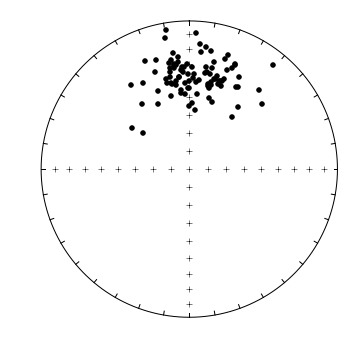

In [61]:
example_file = open('/Users/lukefairchild765/GitHub_files/PmagPy/data_files/find_EI/find_EI_example.dat')
example_read = example_file.readlines()
example_file.close()

example_data = []
for data in example_read:
    data = data.split()
    di = map(float,data)
    example_data.append(di)

plt.figure(figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(di_block=example_data)

In [67]:
data = np.loadtxt('/Users/lukefairchild765/GitHub_files/PmagPy/data_files/find_EI/find_EI_example.dat')
data

array([[  3.51200000e+02,   3.17000000e+01,   4.04989400e+04],
       [  3.49300000e+02,   3.14000000e+01,   1.40405900e+04],
       [  7.60000000e+00,   1.80000000e+01,   1.79373200e+04],
       [  3.37700000e+02,   2.19000000e+01,   1.72905600e+04],
       [  2.30000000e+00,   3.87000000e+01,   2.67425900e+04],
       [  3.51000000e+02,   4.23000000e+01,   4.25707300e+04],
       [  3.00000000e+00,   3.59000000e+01,   4.78731000e+04],
       [  5.00000000e+00,   1.65000000e+01,   2.41004700e+04],
       [  3.53400000e+02,   3.73000000e+01,   4.05467200e+04],
       [  3.58500000e+02,   2.97000000e+01,   3.03962100e+04],
       [  3.50400000e+02,   5.70000000e+00,   6.07690000e+03],
       [  1.28000000e+01,   3.08000000e+01,   2.55029900e+04],
       [  3.46300000e+02,   4.79000000e+01,   3.92817000e+04],
       [  3.57000000e+02,   4.15000000e+01,   2.56681900e+04],
       [  1.55000000e+01,   3.73000000e+01,   1.73398100e+04],
       [  2.26000000e+01,   2.67000000e+01,   2.0930680

In [75]:
a,b,c,d = pmag.find_f(data)
d

[array([ 83.68728343]),
 array([ 83.5354321]),
 array([ 83.37603369]),
 array([ 83.20849339]),
 array([ 83.0321526]),
 array([ 82.84628034]),
 array([ 82.65006327]),
 array([ 82.44259408]),
 array([ 82.22285789]),
 array([ 81.98971643]),
 array([ 81.74188928]),
 array([ 81.47793188]),
 array([ 81.19620947]),
 array([ 80.89486623]),
 array([ 80.57178851]),
 array([ 80.22456105]),
 array([ 79.85041467]),
 array([ 79.44616362]),
 array([ 79.0081306]),
 array([ 78.53205684]),
 array([ 78.01299469]),
 array([ 77.44517948]),
 array([ 76.82187783]),
 array([ 76.1352101]),
 array([ 75.37594597]),
 array([ 74.53327621]),
 array([ 73.59456987]),
 array([ 72.54513874]),
 array([ 71.36805107]),
 array([ 70.04406991]),
 array([ 68.55184005]),
 array([ 66.8685129]),
 array([ 64.97106812]),
 array([ 62.83862953]),
 array([ 60.45600349]),
 array([ 57.81837878]),
 array([ 54.93652944]),
 array([ 51.84105406]),
 array([ 48.5836155]),
 array([ 45.23351411]),
 array([ 41.86956706]),
 array([ 38.56945096])

In [ ]:
def doprinc(data):
    """
    gets principal components from data in form of an array of [dec,inc] data.
    """
    ppars={}
    rad=numpy.pi/180.
    X=dir2cart(data)
    #for rec in data:
    #    dir=[]
    #    for c in rec: dir.append(c)
    #    cart= (dir2cart(dir))
    #    X.append(cart)
#   put in T matrix
#
    T=numpy.array(Tmatrix(X))
#
#   get sorted evals/evects
#
    t,V=tauV(T)
    Pdir=cart2dir(V[0])
    ppars['Edir']=cart2dir(V[1]) # elongation direction
    dec,inc=doflip(Pdir[0],Pdir[1])
    ppars['dec']=dec
    ppars['inc']=inc
    ppars['N']=len(data)
    ppars['tau1']=t[0]
    ppars['tau2']=t[1]
    ppars['tau3']=t[2]
    Pdir=cart2dir(V[1])
    dec,inc=doflip(Pdir[0],Pdir[1])
    ppars['V2dec']=dec
    ppars['V2inc']=inc
    Pdir=cart2dir(V[2])
    dec,inc=doflip(Pdir[0],Pdir[1])
    ppars['V3dec']=dec
    ppars['V3inc']=inc
    return ppars

In [ ]:
def find_f(data):
    rad=np.pi/180.
    Es,Is,Fs,V2s=[],[],[],[]
    ppars=doprinc(data)
    D=ppars['dec']
    Decs,Incs=data.transpose()[0],data.transpose()[1]
    Tan_Incs=np.tan(Incs*rad)
    for f in np.arange(1.,.2 ,-.01):
        U=np.arctan((1./f)*Tan_Incs)/rad
        fdata=numpy.array([Decs,U]).transpose()
        ppars=doprinc(fdata)
        Fs.append(f)
        Es.append(ppars["tau2"]/ppars["tau3"])
        ang = angle([D,0],[ppars["V2dec"],0])
        if 180.-ang<ang:ang=180.-ang
        V2s.append(ang)
        Is.append(abs(ppars["inc"]))
        ###
        if pmag.EI(abs(ppars["inc"]))<=Es[-1]:
            ###
            del Es[-1]
            del Is[-1]
            del Fs[-1]
            del V2s[-1]
            if len(Fs)>0:
                for f in numpy.arange(Fs[-1],.2 ,-.005):
                    U=numpy.arctan((1./f)*Tan_Incs)/rad
                    fdata=numpy.array([Decs,U]).transpose()
                    ppars=doprinc(fdata)
                    Fs.append(f)
                    Es.append(ppars["tau2"]/ppars["tau3"])
                    Is.append(abs(ppars["inc"]))
                    ang=angle([D,0],[ppars["V2dec"],0])
                    if 180.-ang<ang:ang=180.-ang
                    V2s.append(ang)
                    if EI(abs(ppars["inc"]))<=Es[-1]:
                        return Es,Is,Fs,V2s
    return [0],[0],[0],[0]


In [68]:
from IPython.display import clear_output
import sys
def find_EI(data, nb=1000, save = False, save_folder = '.', fmt='svg'):
    """
    Applies series of assumed flattening factor and "unsquishes" inclinations assuming tangent function.
    Finds flattening factor that gives elongation/inclination pair consistent with TK03.  
    Finds bootstrap confidence bounds

    Arguments
    -----------
    data: a nested list of dec/inc pairs
 
    Keywords
    -----------
    nb: number of bootstrapped pseudo-samples (default is 1000)

    Output
    -----------
    four plots:   1) equal area plot of original directions
                  2) Elongation/inclination pairs as a function of f,  data plus 25 bootstrap samples
                  3) Cumulative distribution of bootstrapped optimal inclinations plus uncertainties.
                     Estimate from original data set plotted as solid line
                  4) Orientation of principle direction through unflattening
                      
    NOTE: If distribution does not have a solution, plot labeled: Pathological.  Some bootstrap samples may have
       valid solutions and those are plotted in the CDFs and E/I plot.
    """        
    print "Bootstrapping.... be patient"
    print ""
    sys.stdout.flush()
    
    upper,lower=int(round(.975*nb)),int(round(.025*nb))
    E,I=[],[]
    
    plt.figure(num=1,figsize=(4,4))
    ipmag.plot_net(1)
    ipmag.plot_di(di_block=data)
    
    ppars=pmag.doprinc(data)
    Io=ppars['inc']
    n=ppars["N"]
    Es,Is,Fs,V2s=pmag.find_f(data)
    Inc,Elong=Is[-1],Es[-1]
    
    plt.figure(num=2,figsize=(4,4))
    plt.plot(Is,Es,'r')
    plt.xlabel("Inclination")
    plt.ylabel("Elongation")
    plt.text(Inc,Elong,' %3.1f'%(Fs[-1]))
    plt.text(Is[0]-2,Es[0],' %s'%('f=1'))
    
#     plt.figure(num=PLTS['ei'], figsize=(5,5))
#     plt.figure(num=PLTS['cdf'], figsize=(5,5))
#     plt.figure(num=PLTS['v2'], figsize=(5,5))
    

#     pmagplotlib.drawFIGS(PLTS)
            

#     pmagplotlib.plotEI(PLTS['ei'],Es,Is,Fs[-1])
#     pmagplotlib.plotV2s(PLTS['v2'],V2s,Is,Fs[-1])
    b=0
    
    while b < nb:
        bdata = pmag.pseudo(data)
        Es,Is,Fs,V2s = pmag.find_f(bdata)
        if b<25:
            plt.plot(Is,Es,'y')
#         if len(Es)>0:
        if Es[-1] != 0:
            ppars=pmag.doprinc(bdata)
            I.append(abs(Is[-1]))
            E.append(Es[-1])
        b += 1
#     print lower, upper
    I.sort()
    E.sort()
    Eexp=[]
    for i in I:
        Eexp.append(pmag.EI(i))
    plt.plot(I,Eexp,'g-')
    if Inc==0:
        title= 'Pathological Distribution: '+'[%7.1f, %7.1f]' %(I[lower],I[upper])
    else:
        title= '%7.1f [%7.1f, %7.1f]' %(Inc, I[lower],I[upper])
   
    cdf_fig_num = 3
    plt.figure(num=cdf_fig_num,figsize=(4,4))
    pmagplotlib.plotCDF(cdf_fig_num,I,'Inclinations','r',title)
    pmagplotlib.plotVs(cdf_fig_num,[I[lower],I[upper]],'b','--')
    pmagplotlib.plotVs(cdf_fig_num,[Inc],'g','-')
    pmagplotlib.plotVs(cdf_fig_num,[Io],'k','-')
    
    # plot corrected directional data
    decs, incs = ipmag.unpack_di_block(data)
    unsquished_incs = ipmag.unsquish(incs, Fs[-1])
    plt.figure(num=4,figsize=(4,4))
    ipmag.plot_net(4)
    ipmag.plot_di(decs,unsquished_incs)

    print "The original inclination was: " + str(Io)
    print ""
    print "The corrected inclination is: " + str(Inc)
    print "with bootstrapped confidence bounds of: " +  str(I[lower]) + ' to ' + str(I[upper])
    return Fs

Bootstrapping.... be patient



IndexError: list index out of range

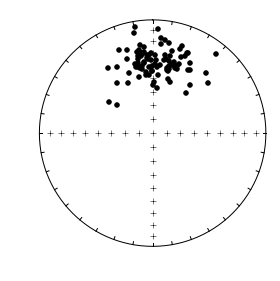

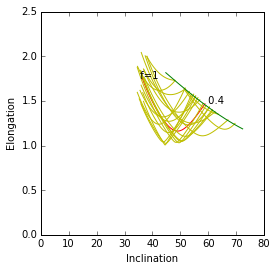

In [69]:
find_EI(data)

In [2]:
ipmag.lat_from_inc(61)

42.051214164410815

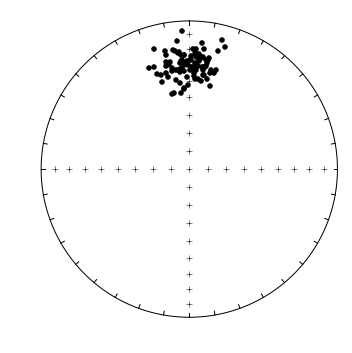

In [3]:
fisher_directions = ipmag.fishrot(k=60, n=100, dec=0, inc=30)
plt.figure(figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(di_block=fisher_directions)

In [4]:
directions = pd.DataFrame(fisher_directions,columns=['dec','inc','length'])
directions.head()

,dec,inc,length
0,353.702729,41.304768,1
1,356.505811,44.420048,1
2,358.093198,29.387006,1
3,8.714331,30.738250,1
4,8.132444,30.942539,1


In [5]:
declinations = directions.dec.tolist()
inclinations = directions.inc.tolist()

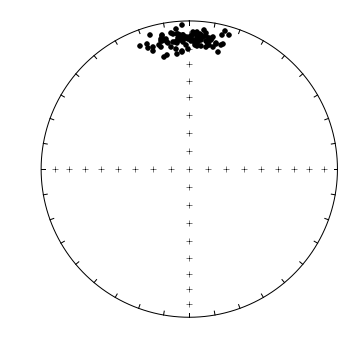

In [6]:
# squish all inclinations
squished_incs = []
for inclination in inclinations:
    squished_incs.append(ipmag.squish(inclination, 0.4))

# plot the squished directional data
plt.figure(num=1,figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(declinations,squished_incs)
squished_DIs = np.array(zip(declinations,squished_incs))

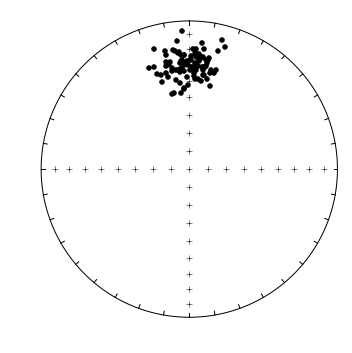

In [7]:
unsquished_incs = []
for squished_inc in squished_incs:
    unsquished_incs.append(ipmag.unsquish(squished_inc, 0.4))

# plot the squished directional data
plt.figure(num=1,figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(declinations,unsquished_incs)

In [11]:
Es,Is,Fs,V2s = pmag.find_f(squished_DIs)
Fs

[0.69999999999999973,
 0.68999999999999972,
 0.67999999999999972,
 0.66999999999999971,
 0.6599999999999997,
 0.64999999999999969,
 0.63999999999999968,
 0.62999999999999967,
 0.61999999999999966,
 0.60999999999999965,
 0.59999999999999964,
 0.58999999999999964,
 0.57999999999999963,
 0.56999999999999962,
 0.55999999999999961,
 0.5499999999999996,
 0.53999999999999959,
 0.52999999999999958,
 0.51999999999999957,
 0.50999999999999956,
 0.49999999999999956,
 0.48999999999999955,
 0.47999999999999954,
 0.46999999999999953,
 0.45999999999999952,
 0.44999999999999951,
 0.4399999999999995,
 0.42999999999999949,
 0.41999999999999948,
 0.40999999999999948,
 0.39999999999999947,
 0.38999999999999946,
 0.37999999999999945,
 0.36999999999999944,
 0.35999999999999943,
 0.34999999999999942,
 0.33999999999999941,
 0.3299999999999994,
 0.3199999999999994,
 0.30999999999999939,
 0.29999999999999938,
 0.28999999999999937,
 0.27999999999999936,
 0.26999999999999935,
 0.25999999999999934,
 0.259999999999

In [70]:
squished_DIs

array([[   6.87313145,   16.71899485],
       [   1.79067614,   15.3014286 ],
       [   5.02772977,   19.61899566],
       [ 347.36817507,    7.13128177],
       [  11.80794232,    8.82373705],
       [  10.06572766,    9.02665221],
       [   0.54100116,    6.98415878],
       [  19.75292203,   15.70178966],
       [ 357.82948614,   11.04105345],
       [ 356.01975625,   21.46508945],
       [   5.88242856,   12.32288257],
       [   6.54414062,   16.46943934],
       [   3.09313744,   15.30561817],
       [   1.22703084,   12.7392839 ],
       [ 348.9426675 ,    7.74246487],
       [  10.52335354,   12.84659312],
       [  10.0498111 ,   15.92313276],
       [ 350.95845354,   11.25369694],
       [   8.35336255,    9.32608711],
       [ 351.708858  ,   16.68008114],
       [ 356.44863093,   18.66138245],
       [ 359.15810867,   14.40650595],
       [ 356.7640979 ,   14.2518303 ],
       [ 353.14360717,   16.33662727],
       [ 351.99991938,   14.58834222],
       [ 357.65055856,   

Bootstrapping.... be patient

The original inclination was: 13.0015202589

The corrected inclination is: 35.6691320939
with bootstrapped confidence bounds of: 29.613816591 to 41.1047865442


[1.0,
 0.98999999999999999,
 0.97999999999999998,
 0.96999999999999997,
 0.95999999999999996,
 0.94999999999999996,
 0.93999999999999995,
 0.92999999999999994,
 0.91999999999999993,
 0.90999999999999992,
 0.89999999999999991,
 0.8899999999999999,
 0.87999999999999989,
 0.86999999999999988,
 0.85999999999999988,
 0.84999999999999987,
 0.83999999999999986,
 0.82999999999999985,
 0.81999999999999984,
 0.80999999999999983,
 0.79999999999999982,
 0.78999999999999981,
 0.7799999999999998,
 0.7699999999999998,
 0.75999999999999979,
 0.74999999999999978,
 0.73999999999999977,
 0.72999999999999976,
 0.71999999999999975,
 0.70999999999999974,
 0.69999999999999973,
 0.68999999999999972,
 0.67999999999999972,
 0.66999999999999971,
 0.6599999999999997,
 0.64999999999999969,
 0.63999999999999968,
 0.62999999999999967,
 0.61999999999999966,
 0.60999999999999965,
 0.59999999999999964,
 0.58999999999999964,
 0.57999999999999963,
 0.56999999999999962,
 0.55999999999999961,
 0.5499999999999996,
 0.539999

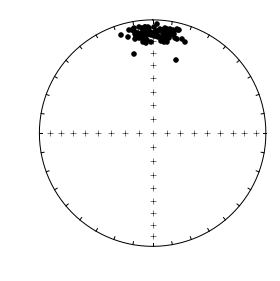

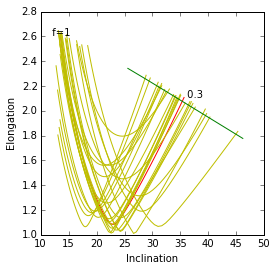

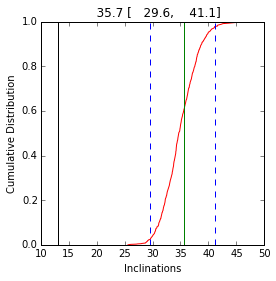

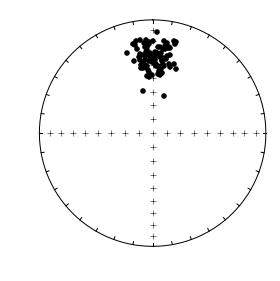

In [32]:
find_EI(data=squished_DIs,nb=1000)

In [13]:
VGPs = ipmag.tk03(n=1000,lat=15) #set at 100,000 this takes a long time to run
VGP_dataframe = pd.DataFrame(VGPs,columns=['dec_tc','inc_tc','int'])
VGP_dataframe['site_lat'] = pd.Series(np.random.uniform(plat,plat,size=len(VGPs)))
VGP_dataframe['site_lon'] = pd.Series(np.random.uniform(0,0,size=len(VGPs)))

ipmag.vgp_calc(VGP_dataframe)    

greater_10 = []
greater_20 = []
greater_30 = []
greater_40 = []
greater_50 = []
angles = []
for n in range(len(VGP_dataframe)):
    true_north = (0,90)
    vgp = (VGP_dataframe['vgp_lon'][n],VGP_dataframe['vgp_lat'][n])
    angle = pmag.angle(true_north,vgp)
    angles.append(angle[0])
    if angle > 10:
        greater_10.append(angle[0])
    if angle > 20:
        greater_20.append(angle[0])
    if angle > 30:
        greater_30.append(angle[0])
    if angle > 40:
        greater_40.append(angle[0])
    if angle > 50:
        greater_50.append(angle[0])
    
n, bins, patches = plt.hist(angles, bins=50)
plt.vlines(50.6,0,5000,linestyles='dotted')
plt.xlim(0,90)
plt.ylim(0,n.max())
plt.xlabel('angle between TK03.GAD VGP and geographic north')
plt.ylabel('n')
plt.show()

NameError: name 'plat' is not defined